In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from alib.vis_utils import *

In [2]:
# clustering analysis
f = open(f'feas_pred.pkl', 'rb')
feas_pred_df = pickle.load(f)
f.close()

selected_df = feas_pred_df.copy()
selected_df['Score'] = np.clip(selected_df.epsilon_10 - 600, None, 0) / 500.0 + \
                       np.clip(selected_df.conductance - 10, None, 0) / 10

selected_df = selected_df.sort_values(by='Score', ascending=False, ignore_index=True)
selected_df = selected_df[selected_df.Score >= 0]
selected_df

x_cols = selected_df.columns
X = selected_df[x_cols[:10]]

plot_X = X[['CNT', 'MXN', 'PVA']]
X = X.values / X.values.max(axis=1).reshape(-1, 1)

db = DBSCAN(eps=0.05, min_samples=70).fit(plot_X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_ = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_)) - (1 if -1 in labels_ else 0)

print("Estimated number of clusters: %d" % n_clusters_)

Estimated number of clusters: 1


In [3]:
# Feasible Area

df_train = pd.read_csv('db_train.csv')
df_test = pd.read_csv('db_test.csv')

X_COLS = ['MXene', 'SWNT', 'PVA']
Y_COLS = ['LRR']

X_train = df_train[X_COLS].values
y_train = df_train[Y_COLS].values.flatten()

search_space = {    
    'C': (1e-1, 1e+4, 'log-uniform'),
    'gamma': (1e-1, 5e+1, 'log-uniform')
}

opt = GridSearchCV(SVR(), search_space, n_jobs=16, scoring='neg_mean_absolute_error',
            cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=0))

opt.fit(X_train, y_train)

opt = SVR(C=100, gamma=1.5).fit(X_train, y_train)

num_points = 551
margin = 0.05
grid_space = (1 + 2 * margin) / (num_points - 1)
x, y, z = np.mgrid[-margin:1+margin:num_points * 1j, -margin:1+margin:num_points * 1j, -margin:1+margin:num_points * 1j]
prob = opt.predict(np.array([x.flatten(), y.flatten(), z.flatten()]).T).reshape(x.shape)

prob[(np.abs(x) + np.abs(y) + np.abs(z) > 1) | (x < 0) | (y < 0) | (z < 0)] = 0
# prob[(x > 0.20) & (x < 0.60) & (y < 0.2) & (z > 0)] = 0

cutoff = 0.454
verts, faces, _, _ = marching_cubes(prob, level=cutoff,spacing=(grid_space, )*3, )
verts -= margin

poly = skimg_tri_to_poly(verts, faces)
smooth_poly = smooth_pvs_poly(poly, sm_iters=200, sm_rlx=0.1, dp_factor=0.5, dp_angle=180, dp_iters=50, dp_error=0.0002)
verts2, faces2 = poly_to_skimg_tri(smooth_poly)

verts[verts[:,2] <= 0.001]

array([[-3.60870361e-06,  1.82000000e-01,  0.00000000e+00],
       [ 0.00000000e+00,  1.82000000e-01, -3.60870361e-06],
       [ 0.00000000e+00,  1.81337692e-01,  0.00000000e+00],
       ...,
       [ 1.00000000e+00,  5.46459198e-04,  0.00000000e+00],
       [ 9.98547363e-01,  2.00000000e-03,  0.00000000e+00],
       [ 1.00054651e+00,  0.00000000e+00,  0.00000000e+00]])

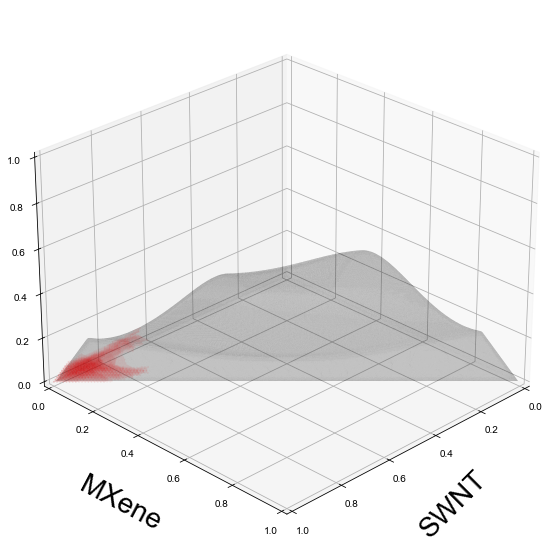

In [4]:
mpl.rcParams['font.size'] = 28
mpl.rcParams['font.family'] = 'Arial'

def style_db_ax(ax, pad_scale=-2.0):
    ax.zaxis.set_rotate_label(False)
    [getattr(ax, f'set_{a}label')(l, labelpad=p * pad_scale * 3, rotation=r, fontsize=28) for a, l, r, p in zip('xyz', 
                                                                                   ['SWNT', 'MXene', 'PVA'],                                     
                                                                                   [45, -20, 90],
                                                                                   [-4, -4, -2])]
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')

surf = ax.plot_trisurf(verts2[:, 0], verts2[:,1], faces2, verts2[:, 2], color=(0.3, 0.3, 0.3, 0.15), label='Feasible Space')
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d

for l, c in zip(range(n_clusters_), plt.get_cmap('Set1').colors):
    ax.scatter(*plot_X[labels_ == l].values.T, c=c, alpha=0.05, label=f'Cluster {l + 1}', s=1)

[getattr(ax, f'set_{a}lim')(0, 1) for a in 'xyz']
style_db_ax(ax)
ax.view_init(27,45)